In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
from tqdm.autonotebook import tqdm
from scipy import signal

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Experiments to process
experiment_ids = ['historical', 'ssp370']
experiment_ids1 = ['historical']

# Seasons to process
seasons = ['all','DJF','JJA']

# Time slices (future) to process
time_slices = ([['1991','2020'],
                ['2001','2030'],
                ['2011','2040'],
                ['2021','2050'],
                ['2031','2060'],
                ['2041','2070'],
                ['2051','2080'],
                ['2061','2090'],
                ['2071','2100']])


In [3]:
# Read data locations
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

In [4]:
# Subset to monthly precipitation (let's just look at one run per model for now)
df_mon_pr = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'pr')
                 & (df.member_id == "r1i1p1f1"))])

In [5]:
# Get names of all the models in the subset
pr_source_ids = []
for name, group in df_mon_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        pr_source_ids.append(name)

In [6]:
# Subset to monthly tas (let's just look at one run per model for now)
df_mon_tas = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'tas')
                 & (df.member_id == "r1i1p1f1"))])

In [7]:
# Get names of all the models in the subset
tas_source_ids = []
for name, group in df_mon_tas.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        tas_source_ids.append(name)

In [8]:
# Get names of all the models in the subset
df_areacella = (df[((df.table_id == 'fx') 
                 & (df.variable_id == 'areacella')
                 & (df.member_id == "r1i1p1f1"))])

areacella_source_ids = []
for name, group in df_areacella.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids1]):
        areacella_source_ids.append(name)
areacella_source_ids

['CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'E3SM-1-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MCM-UA-1-0',
 'MIROC6',
 'MRI-ESM2-0',
 'SAM0-UNICON']

In [9]:
tas_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [10]:
pr_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'FGOALS-g3',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [11]:
source_ids=list(set(tas_source_ids).intersection(pr_source_ids))
source_ids

['MRI-ESM2-0',
 'BCC-CSM2-MR',
 'CESM2',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'CAMS-CSM1-0',
 'CESM2-WACCM',
 'CanESM5',
 'MIROC6',
 'BCC-ESM1']

In [12]:
source_ids_areacella=list(set(tas_source_ids).intersection(pr_source_ids).intersection(areacella_source_ids))
source_ids_areacella

['MRI-ESM2-0',
 'CESM2',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'CESM2-WACCM',
 'MIROC6',
 'CanESM5']

In [13]:
# Function to load data: df_data has the catalogue of the variable of interest
def load_data(df_data, source_id, expt_id):
    """
    Load data for given variable, source and expt ids.
    """
    uri = df_data[(df_data.source_id == source_id) &
                  (df_data.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [14]:
def spatial_average(field,lat_or_spatial_weights,latitude):
    if lat_or_spatial_weights is not None:
        field_mean = np.average(field,weights=lat_or_spatial_weights.areacella)
    else:
        # Use the cosine of the converted latitudes as weights for the average
        field_mean = np.average(field.mean("lon"),weights=np.cos(np.deg2rad(latitude)))
    return field_mean

In [15]:
# Function to get mean and variability and their changes
def mean_dtas_calc(data_tmp,seas='all', weights_in=None):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    
        
    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .tas.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .tas.mean('time'))

    # Take the spatial average 
    latitude=data_tmp['hist'].lat
    mu_histG = spatial_average(mu_hist,weights_in,latitude)
    mu_futrG = spatial_average(mu_futr,weights_in,latitude)
        
    dtasG = mu_futrG-mu_histG

    # Out 
    outp = xr.Dataset(
        data_vars = {'dtasG':    ([],dtasG)}
        )


#     return(outp)
    return(dtasG)

In [15]:
tdata = {}

times = []
for mod_name in tqdm(source_ids):
    print('\n\nStarting '+mod_name+'\n')
    ds_hist = load_data(df_mon_tas, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
    ds_ssp  = load_data(df_mon_tas, mod_name, experiment_ids[1])

    try: # try getting areacella data
        ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])

    except: #if not available, flag it as 0. It will use np.cos(lat)
        ds_areacella = None

    tdata[mod_name] = {}
    tresults[mod_name] = {}

    for time_slice in time_slices:
        print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
        if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
            print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
            break

        # Get corresponding temporal slice of data and stage it
        ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
        tdata[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}


        tresults[mod_name]["t"+time_slice[0]] = {}
       # Calculate means, sds,...
        tresults[mod_name]['t'+time_slice[0]] = mean_dtas_calc(tdata[mod_name]['t'+time_slice[0]],
                                                               seas = 'all', weights_in=ds_areacella)
        print(' processed!')

        print(time_slice[0]+'-'+time_slice[1]+' processed!')

    print(mod_name+' processed!')




Starting BCC-ESM1

Begin processing time slice 1991-2020
 processed!
1991-2020 processed!
Begin processing time slice 2001-2030
 processed!
2001-2030 processed!
Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
Future time series only goes until 2055
BCC-ESM1 processed!


Starting IPSL-CM6A-LR

Begin processing time slice 1991-2020
 processed!
1991-2020 processed!
Begin processing time slice 2001-2030
 processed!
2001-2030 processed!
Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
 processed!
2031-2060 processed!
Begin processing time slice 2041-2070
 processed!
2041-2070 processed!
Begin processing time slice 2051-2080
 processed!
2051-2080 processed!
Begin processing time slice 2061-2090
 processed!
2061-2090 processed!
Begi

In [16]:
temp_da.to_dataframe()

,CAMS-CSM1-0,IPSL-CM6A-LR,MRI-ESM2-0,CESM2-WACCM,CanESM5,GFDL-ESM4,CESM2,MIROC6,BCC-CSM2-MR,BCC-ESM1
1991,0.666351,0.802085,0.350626,0.718262,0.768097,0.905243,0.589783,0.716827,0.376282,0.760193
2001,0.791522,0.950498,0.492920,0.917542,0.877380,1.198212,0.695282,0.845734,0.547302,0.897766
2011,0.964405,1.080176,0.585576,1.094421,1.007812,1.438416,0.812836,1.021454,0.697571,1.023926
2021,1.241890,1.282089,0.772982,1.337646,1.271332,1.863525,1.021606,1.346252,0.924072,1.267822
t2031,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],NaN
t2041,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],NaN
t2051,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],NaN
t2061,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],NaN
t2071,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],NaN


In [19]:
temp_da.to_dataframe().to_csv('tresults.csv')

In [15]:
tresults_new=pd.read_csv('tresults.csv',index_col=0)
tresults_new

CAMS-CSM1-0  IPSL-CM6A-LR  MRI-ESM2-0  CESM2-WACCM   CanESM5  \
t1991     0.350626      0.716827    0.760193     0.768097  0.905243   
t2001     0.492920      0.845734    0.897766     0.877380  1.198212   
t2011     0.585576      1.021454    1.023926     1.007812  1.438416   
t2021     0.772982      1.346252    1.267822     1.271332  1.863525   
t2031     0.993943      1.789948    1.614258     1.642242  2.394562   
t2041     1.272332      2.248840    1.980377     2.098663  2.996094   
t2051     1.531312      2.722992    2.343811     2.548523  3.578979   
t2061     1.834118      3.222717    2.689697     3.027191  4.184479   
t2071     2.101574      3.826843    3.042175     3.494812  4.786499   

       GFDL-ESM4     CESM2    MIROC6  BCC-CSM2-MR  BCC-ESM1  
t1991   0.589783  0.718262  0.376282     0.666351  0.802085  
t2001   0.695282  0.917542  0.547302     0.791522  0.950498  
t2011   0.812836  1.094421  0.697571     0.964405  1.080176  
t2021   1.021606  1.337646  0.924072     1.241890  1.282089  
t2031   1.295166  1.657043  1.235840     1.599642       NaN  
t2041   1.631042  2.027405  1.533264     1.969405       NaN  
t2051   2.001801  2.485107  1.861328     2.325534       NaN  
t2061   2.398132  3.025238  2.143311     2.711012       NaN  
t2071   2.761627  3.541107  2.475281     3.085562       NaN

In [16]:
tresults_dict=tresults_new.to_dict()

In [17]:
dt=np.zeros((len(time_slices),len(tresults_dict)))*np.nan 
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in tresults_dict[model]:
        dt[timecount,modelcount]=tresults_dict[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1

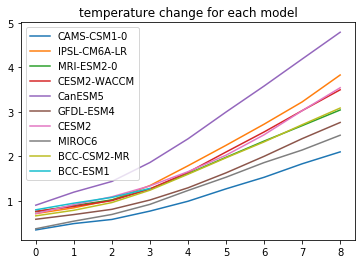

In [18]:
# PRECIP

In [19]:
# Function to get mean and variability and their changes
def mean_var_calc(data_tmp,seas='all',weights_in=None):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    

    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .pr.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .pr.mean('time'))
    
    # Take the spatial average 
    latitude=data_tmp['hist'].lat
    mu_histG = spatial_average(mu_hist,weights_in,latitude)
    mu_futrG = spatial_average(mu_futr,weights_in,latitude)

    # Calculate standard deviation of detrended series
    sd_hist = (xr.apply_ufunc(signal.detrend, data_tmp['hist'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['hist'].isnull())
               .sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .std("time")).pr
    sd_futr = (xr.apply_ufunc(signal.detrend, data_tmp['futr'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['futr'].isnull())
               .sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .std("time")).pr

    # Take the spatial average of variance
    # Calculate variance
    var_hist = sd_hist ** 2    
    var_histG = spatial_average(var_hist,weights_in,latitude)
    sd_histG = np.sqrt(var_histG)

    var_futr = sd_futr ** 2
    var_futrG = spatial_average(var_futr,weights_in,latitude)
    sd_futrG = np.sqrt(var_futrG)
    
    # calculate changes
    dmuG = mu_futrG/mu_histG
    dsdG = sd_futrG/sd_histG

    # Out 
    outp = xr.Dataset(
        data_vars = {'dmuG':    ([],dmuG),
                     'dsdG':    ([],dsdG)},
        )

    return(outp)

In [20]:
source_ids_areacella

['MRI-ESM2-0',
 'CESM2',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'CESM2-WACCM',
 'MIROC6',
 'CanESM5']

In [21]:
data = {}
models = []

for mod_name in tqdm(source_ids):
    print('\n\nStarting '+mod_name+'\n')
    ds_hist = load_data(df_mon_pr, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
    ds_ssp  = load_data(df_mon_pr, mod_name, experiment_ids[1])
    try: # try getting areacella data
        ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])

    except: #if not available, flag it as 0. It will use np.cos(lat)
        ds_areacella = None

    data[mod_name] = {}
    results[mod_name] = {}

    for time_slice in time_slices:
        print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
        if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
            print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
            break

       # Get corresponding temporal slice of data and stage it
        ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
        data[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}


        results[mod_name]["t"+time_slice[0]] = {}

## implement this later, for now just do DJF 
#       for seas in seasons:
            # Calculate means, sds,...
        seas='DJF'
        results[mod_name]['t'+time_slice[0]][seas] = mean_var_calc(data[mod_name]['t'+time_slice[0]],seas, weights_in = ds_areacella)
        #print(seas+' processed!')

        print(time_slice[0]+'-'+time_slice[1]+' processed!')

    print(mod_name+' processed!')




Starting MRI-ESM2-0

Begin processing time slice 1991-2020
1991-2020 processed!
Begin processing time slice 2001-2030
2001-2030 processed!
Begin processing time slice 2011-2040
2011-2040 processed!
Begin processing time slice 2021-2050
2021-2050 processed!
Begin processing time slice 2031-2060
2031-2060 processed!
Begin processing time slice 2041-2070
2041-2070 processed!
Begin processing time slice 2051-2080
2051-2080 processed!
Begin processing time slice 2061-2090
2061-2090 processed!
Begin processing time slice 2071-2100
2071-2100 processed!
MRI-ESM2-0 processed!


Starting BCC-CSM2-MR

Begin processing time slice 1991-2020
1991-2020 processed!
Begin processing time slice 2001-2030
2001-2030 processed!
Begin processing time slice 2011-2040
2011-2040 processed!
Begin processing time slice 2021-2050
2021-2050 processed!
Begin processing time slice 2031-2060
2031-2060 processed!
Begin processing time slice 2041-2070
2041-2070 processed!
Begin processing time slice 2051-2080
2051-208

In [22]:
# here below you select one season and dsdG or dmuG, then you reshape it like a 2D pandas dataframe

['MRI-ESM2-0',
 'CESM2',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'CESM2-WACCM',
 'MIROC6',
 'CanESM5']

In [23]:
dsdG_djf = temp_dapr.sel(season='DJF').dsdG
# transform to dataframe
df_dsdG_djf = dsdG_djf.to_dataframe()
#reshape it to a 2D dataframe, with time and model_name as index and columns
df_dsdG_djf = df_dsdG_djf.reset_index()[['model_name','time','dsdG']].pivot(
                                        index = 'time', columns='model_name', values = 'dsdG')
df_dsdG_djf

In [24]:
pd.DataFrame(df_dsdG_djf).to_csv('dsdG_djf.csv')


In [25]:
pd.DataFrame(dsdG_djf)

,MRI-ESM2-0,BCC-CSM2-MR,CESM2,GFDL-ESM4,IPSL-CM6A-LR,CAMS-CSM1-0,CESM2-WACCM,CanESM5,MIROC6,BCC-ESM1
t1991,0.927374,0.982603,1.017618,1.035774,1.041305,0.970020,1.022184,1.041476,0.983910,0.963441
t2001,0.965627,1.012408,1.030965,1.034346,1.061704,0.998661,1.021454,1.072001,1.027627,1.002681
t2011,0.958772,1.038669,1.066046,1.030939,1.069258,1.013537,1.039816,1.079521,1.004109,1.018551
t2021,0.983005,1.057812,1.082278,1.034678,1.065308,1.025562,1.060674,1.108786,1.006428,1.032016
t2031,1.008734,1.070512,1.105388,1.057237,1.087724,1.045689,1.109779,1.127890,0.993048,NaN
t2041,1.094887,1.073504,1.121343,1.090690,1.111745,1.043397,1.121593,1.151836,1.029917,NaN
t2051,1.142753,1.082534,1.147366,1.102006,1.158009,1.049514,1.145935,1.170736,1.034896,NaN
t2061,1.158891,1.092499,1.186820,1.095531,1.194014,1.042049,1.157643,1.208483,1.038537,NaN
t2071,1.161113,1.105286,1.213157,1.099062,1.237170,1.059414,1.191385,1.239221,1.048009,NaN


In [26]:
pd.DataFrame(dsdG_djf).to_csv('dsdG_djf.csv')

In [27]:
dsdG_djf_new=pd.read_csv('dsdG_djf.csv',index_col=0)
dsdG_djf_new


,MRI-ESM2-0,BCC-CSM2-MR,CESM2,GFDL-ESM4,IPSL-CM6A-LR,CAMS-CSM1-0,CESM2-WACCM,CanESM5,MIROC6,BCC-ESM1
t1991,0.927374,0.982603,1.017618,1.035774,1.041305,0.970020,1.022184,1.041476,0.983910,0.963441
t2001,0.965627,1.012408,1.030965,1.034346,1.061704,0.998661,1.021454,1.072001,1.027627,1.002681
t2011,0.958772,1.038669,1.066046,1.030939,1.069258,1.013537,1.039816,1.079521,1.004109,1.018551
t2021,0.983005,1.057812,1.082278,1.034678,1.065308,1.025562,1.060674,1.108786,1.006428,1.032016
t2031,1.008734,1.070512,1.105388,1.057237,1.087724,1.045689,1.109779,1.127890,0.993048,NaN
t2041,1.094887,1.073504,1.121343,1.090690,1.111745,1.043397,1.121593,1.151836,1.029917,NaN
t2051,1.142753,1.082534,1.147366,1.102006,1.158009,1.049514,1.145935,1.170736,1.034896,NaN
t2061,1.158891,1.092499,1.186820,1.095531,1.194014,1.042049,1.157643,1.208483,1.038537,NaN
t2071,1.161113,1.105286,1.213157,1.099062,1.237170,1.059414,1.191385,1.239221,1.048009,NaN


In [28]:
dsdG_djf=dsdG_djf_new.to_dict()


In [29]:
dsdG_djf_np=np.zeros((len(time_slices),len(dsdG_djf)))*np.nan 


In [30]:
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in dsdG_djf[model]:
        dsdG_djf_np[timecount,modelcount]=dsdG_djf[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1


KeyError: 'BCC-CSM2-MR'

In [31]:
dsdG_djf_np

array([[0.97001951, 1.0413053 , 0.92737365, 1.0221839 , 1.04147601,
        1.03577399, 1.01761818, 0.98390967, 0.98260308, 0.96344096],
       [0.99866134, 1.06170416, 0.9656269 , 1.02145362, 1.07200062,
        1.0343461 , 1.03096521, 1.02762699, 1.01240815, 1.00268099],
       [1.01353749, 1.06925786, 0.95877194, 1.03981602, 1.07952094,
        1.03093898, 1.06604552, 1.00410914, 1.03866912, 1.01855125],
       [1.02556207, 1.06530845, 0.98300475, 1.06067407, 1.10878611,
        1.03467751, 1.08227813, 1.00642753, 1.05781245, 1.03201613],
       [1.04568893, 1.08772409, 1.00873399, 1.10977948, 1.12788951,
        1.05723727, 1.10538793, 0.99304754, 1.07051213,        nan],
       [1.04339748, 1.11174512, 1.0948875 , 1.121593  , 1.1518364 ,
        1.09069026, 1.12134326, 1.02991724, 1.07350369,        nan],
       [1.04951387, 1.15800941, 1.14275289, 1.14593542, 1.17073643,
        1.10200596, 1.1473664 , 1.03489614, 1.08253419,        nan],
       [1.04204886, 1.19401419, 1.1588907

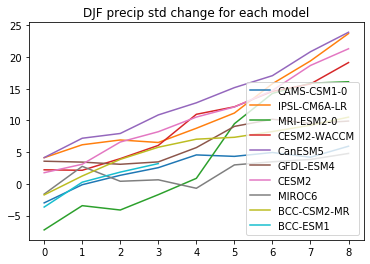

In [32]:
plt.plot((dsdG_djf_np-1)*100)
plt.title('DJF precip std change for each model')
plt.legend(modelnames)